<a href="https://colab.research.google.com/github/nanthan987/8-puzzle/blob/master/CBL_project/nanthan987/SLIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import scipy
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import time
import pickle
import os
import glob

In [2]:
# Installing OpenCV version 3.4.2.16 which has SIFT algorithm included (v>3.4.2 does not include SIFT)
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


     |████████████████████████████████| 30.6MB 149kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import drive,files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ln -s /content/drive/MyDrive/cbl_40/3_dsm_ortho/2_mosaic/tiles cbl_40_tiles

In [4]:
# load the image and convert it to a floating point data type
img_file = "cbl_40_tiles/cbl_40_transparent_mosaic_group1_1_2.tif"
# img_file = 'conr_stich.jpg'
# image = img_as_float(io.imread(img_file,plugin='pil'))
image = Image.open(img_file).convert("RGB")
image_float = img_as_float(image)
image = np.array(image)

## **Building and installing lear-gist-python**

In [ ]:
!git clone https://github.com/whitphx/lear-gist-python.git

In [ ]:
%cd lear-gist-python/

In [ ]:
!sudo apt install libfftw3-dev

In [ ]:
!./download-lear.sh

In [ ]:
!python setup.py build_ext

In [ ]:
!python setup.py install

In [ ]:
%cd /content/

## **Tuning SLIC parameters**

In [6]:
# Helper function
def display_and_save_superpixels(image,segments,num_segments,additional_tags,download=True):
  fig = plt.figure("Superpixels -- %d segments" % (num_segments))
  ax = fig.add_subplot(1, 1, 1)
  boundaries = mark_boundaries(image, segments,color=(0, 0, 1))
  ax.imshow(boundaries)
  plt.axis("off")
  boundaries = boundaries*255
  boundaries_img = Image.fromarray(boundaries.astype(np.uint8))
  boundaries_img.save(f'boundaries_{num_segments}_{additional_tags}.jpg')
  # show the plots
  plt.show()
  if download:
    files.download(f'boundaries_{num_segments}_{additional_tags}.jpg')


Trying different compactness values on a log scale

In [ ]:
numSegments=500

# try different compactness values
for compactness in tqdm((0.01, 0.1, 1, 10, 100)):
  segments = slic(image_float, n_segments = numSegments,compactness=compactness, sigma = 5)
  # show the output of SLIC
  display_and_save_superpixels(image_float,segments,numSegments,f"c{compactness}")
  

Values of 0.01,0.1,1 do not capture region boundaries well

A value of 100 gives superpixels that are too square

A compactness value between 10 and 50 would be more appropriate

In [ ]:
numSegments = 1300
compactness = 20

t = time.process_time()
segments = slic(image_float, n_segments = numSegments,compactness=compactness, sigma = 1)
elapsed_time = time.process_time() - t
print("Time elapsed: ",elapsed_time)

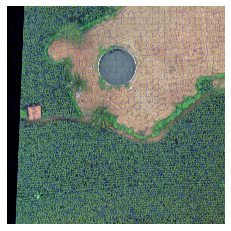

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# show the output of SLIC
display_and_save_superpixels(image_float,segments,numSegments,f"c{compactness}",download=False)

After some trial and error, it is found that for these images, a high **cluster value of 1300** gives superpixels which identify most of the important boundaries since the objects in the images are smaller due to the height from which the image is taken.

A **compactness value of 20** gives superpixels enough irregularity to capture necessary boundariesw ithout becoming too irregular.

### **Trying SLICO algorithm**
Zero parameter version of SLIC algorithm

https://www.epfl.ch/labs/ivrl/research/slic-superpixels/#SLICO

In [ ]:
numSegments = 1300

segments = slic(image_float, n_segments = numSegments, sigma = 1,slic_zero=True)
# show the output of SLIC
display_and_save_superpixels(image_float,segments,numSegments,"slic_zero")

Even though the SLIC0 algorithm works well, for the same number of segments, the SLIC algorithm with compactness of 20 is better at capturing region boundaries for this image

## **Accessing individual superpixels**

In [8]:
def get_segment_masks(segments):
  for segment_val in np.unique(segments):
    mask = np.zeros(segments.shape[:2],dtype="uint8")
    mask[segments == segment_val] = 255
    yield (segment_val,mask)

In [9]:
def get_superpixel_mask(segments, segment_val):
  mask = np.zeros(segments.shape[:2],dtype="uint8")
  mask[segments==segment_val] = 255
  return mask


In [10]:
def get_superpixel(image,mask):
  x1,y1,w,h = cv2.boundingRect(mask)
  x2 = x1 + w
  y2 = y1 + h
  # return (cv2.bitwise_and(image,image,mask=mask)[y1:y2,x1:x2],mask[y1:y2,x1:x2])
  return image[y1:y2,x1:x2],mask[y1:y2,x1:x2]

## **Saving superpixels and respective masks to files**

In [11]:
%mkdir superpixels
%mkdir superpixels/masks

In [12]:
for segVal,mask in get_segment_masks(segments):
  superpixel,sp_mask = get_superpixel(image,mask)
  cv2.imwrite(f"/content/superpixels/superpixel_{segVal}.jpg",superpixel)
  with open(f"/content/superpixels/masks/mask_{segVal}.pkl","wb") as mask_file:
    pickle.dump(mask,mask_file)

## **Feature extraction**

In [13]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation

In [14]:
# Helper function to display clustered superpixels
def display_clusters(labels,segments,image):
  for label in np.unique(labels):
    cluster_mask = np.zeros(segments.shape[:2],dtype="uint8")
    cluster = np.where(labels == label)[0]
    for segVal in cluster:
      superpixel_mask= get_superpixel_mask(segments, segVal)
      cluster_mask = cv2.bitwise_or(cluster_mask,superpixel_mask)
    print("Cluster label: ",label)
    cluster_image = cv2.bitwise_and(image,image,mask = cluster_mask)
    cluster_image_lowres = cv2.resize(cluster_image, (700, 700))
    cv2_imshow(cluster_image_lowres)

### **GIST**

In [ ]:
import gist

In [ ]:
gist_features = []

t = time.process_time()
for segVal,mask in get_superpixel_masks(segments):
  print(segVal)
  x1,y1,w,h = cv2.boundingRect(mask)
  x2 = x1 + w
  y2 = y1 + h
  superpixel_region = cv2.bitwise_and(image,image,mask=mask)[y1:y2,x1:x2]
  gist_features.append(gist.extract(superpixel_region))

elapsed_time = time.process_time() - t
print("Time elapsed: ",elapsed_time)

**Clustering GIST features using KMeans**

In [ ]:
km = KMeans(n_clusters=2).fit(gist_features)
print("================== Number of clusters = 2 ======================")
display_clusters(km.labels_,segments,image)

**GIST method does not provide good results since the corn field is not properly segmented at all**

### **KAZE -test**

In [ ]:
def kaze_match(im1,mask1, im2,mask2):
    # load the image and convert it to grayscale
    # im1 = cv2.imread(im1_path)
    # im2 = cv2.imread(im2_path)
    gray1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)    

    # initialize the AKAZE descriptor, then detect keypoints and extract
    # local invariant descriptors from the image
    detector = cv2.AKAZE_create()
    cv2_imshow(mask1)
    (kps1, descs1) = detector.detectAndCompute(gray1, mask1)
    (kps2, descs2) = detector.detectAndCompute(gray2, mask2)
    # (kps1, descs1) = detector.detectAndCompute(gray1, None)
    # (kps2, descs2) = detector.detectAndCompute(gray2, None)
    print(type(descs1))
    if isinstance(descs1,type(None)):
      descs1 = np.array([])
    if isinstance(descs2,type(None)):
      descs2 = np.array([])
    print("keypoints: {}, descriptors: {}".format(len(kps1), descs1.shape))
    print("keypoints: {}, descriptors: {}".format(len(kps2), descs2.shape))    

    # Match the features
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(descs1,descs2, k=2)    # typo fixed

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.9*n.distance:
            good.append([m])
    print(len(good))
    # cv2.drawMatchesKnn expects list of lists as matches.
    im3 = cv2.drawMatchesKnn(im1, kps1, im2, kps2, good[1:20], None, flags=2)
    cv2_imshow(im3)
    

In [ ]:

superpixel1,mask1 = get_superpixel(image,get_superpixel_mask(segments,900))

superpixel2,mask2 = get_superpixel(image,get_superpixel_mask(segments,1010))

cv2_imshow(superpixel1)
cv2_imshow(superpixel2)

In [ ]:
kaze_match(superpixel1,mask1,superpixel2,mask2)

### **KAZE - Constant size descriptor**

The following code computes a fixed size 2048-dimensional vector feature descriptor for each superpixel using the OpenCV KAZE algorithm. A mask is used so that only the superpixel region in the rectangular image is considered to find keypoints.

In [ ]:
# Feature extractor
def extract_features(image_path,mask_path, vector_size=32):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # get mask for the image
    with open(mask_path,"rb") as mask_file:
      mask = pickle.load(mask_file)

    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        #If descriptor is None, assign it an empty np array
        if isinstance(dsc,type(None)):
          dsc = np.array([])
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="features.pck"):
    # files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    path = f"{images_path}*.jpg"
    print(path)
    files = glob.glob(path)
    files.sort()

    result = {}
    for f in files:
        print(f'Extracting features from image {f}')
        name = f.split('/')[-1].lower()
        mask_path = f"{images_path}masks/mask_{name[11:-4]}.pkl"
        result[name] = extract_features(f,mask_path)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [ ]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path,"rb") as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, mask_path, topn=5):
        features = extract_features(image_path,mask_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [ ]:
def show_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = '/content/superpixels/'
    # files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    files = glob.glob(f"{images_path}*jpg")
    files.sort()
    # getting 3 random images 
    sample = files[4:25]
    
    # Extract features from all images. Uncomment if features havent been found yet
    # batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for sample_img in sample:
        print('Query image ==========================================')
        show_img(sample_img)
        name = sample_img.split('/')[-1].lower()
        mask_path = f"{images_path}masks/mask_{name[11:-4]}.pkl"
        names, match = ma.match(sample_img, mask_path, topn=10)
        print('Result images ========================================')
        for i in range(10):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print(f'Match {(1-match[i])}')
            show_img(os.path.join(images_path, names[i]))

run()

The script outputs the top 10 best matches for the chosen query images

KAZE features are clearly able to capture key information about the images well. Computation time is quite long for extracting images. However, since the number of superpixels is very high(>1000) it is expected.

**K-Means clustering on KAZE features using different numbers of clusters**

In [ ]:
# To cluster KAZE features
with open("features.pck","rb") as feature_file:
  feature_dict = pickle.load(feature_file)
KAZE_features = [0 for i in range(len(feature_dict))]
for filename,feature in feature_dict.items():
  segVal = int(filename[11:-4])
  KAZE_features[segVal] = feature

KAZE_features = np.array(KAZE_features)

In [ ]:
for num_clusters in range(2,6):
  km = KMeans(n_clusters=num_clusters).fit(KAZE_features)
  print("================== Number of clusters = ",num_clusters,"  ======================")
  display_clusters(km.labels_,segments,image)

**While the algorithm is able to cluster most of the corn filed superpixels together, there are alot of other superpixels that get clustered together with them. The result is not ideal**

### **Bag of Visual Words (BoVW) based on SIFT**

In [15]:
from scipy import ndimage
from scipy.spatial import distance

def load_images_from_folder(folder):
  files = glob.glob(f"{folder}*.jpg")
  files.sort()
  for image_file in files:
    image = cv2.imread(image_file)
    # load image mask
    image_name = image_file.split("/")[-1]
    mask_name = f"{folder}masks/mask_{image_name[11:-4]}.pkl"
    with open(mask_name,'rb') as mask_file:
      mask = pickle.load(mask_file)
    yield image_name, cv2.cvtColor(image,cv2.COLOR_BGR2RGB), mask


In [16]:
# Creates descriptors using sift 
# Takes one parameter that is path of images
# Returns a dictionary with features/descriptors for each image and a list of all sift keypoint descriptors
def sift_features(folder):
  sift = cv2.xfeatures2d.SIFT_create()

  image_features = {}
  all_features = []

  count = 0
  for image_name, image, mask in load_images_from_folder(folder):
    count+=1
    print("completed: ",count)
    
    kp, des = sift.detectAndCompute(image,None)
    if isinstance(des,type(None)):
      des = np.array([],dtype="float32")
    image_features[f"{image_name[11:-4]}"] = des
    all_features.extend(des)


  return image_features,np.array(all_features)

image_features,all_features = sift_features("/content/superpixels/") 

completed:  1
completed:  2
completed:  3
completed:  4
completed:  5
completed:  6
completed:  7
completed:  8
completed:  9
completed:  10
completed:  11
completed:  12
completed:  13
completed:  14
completed:  15
completed:  16
completed:  17
completed:  18
completed:  19
completed:  20
completed:  21
completed:  22
completed:  23
completed:  24
completed:  25
completed:  26
completed:  27
completed:  28
completed:  29
completed:  30
completed:  31
completed:  32
completed:  33
completed:  34
completed:  35
completed:  36
completed:  37
completed:  38
completed:  39
completed:  40
completed:  41
completed:  42
completed:  43
completed:  44
completed:  45
completed:  46
completed:  47
completed:  48
completed:  49
completed:  50
completed:  51
completed:  52
completed:  53
completed:  54
completed:  55
completed:  56
completed:  57
completed:  58
completed:  59
completed:  60
completed:  61
completed:  62
completed:  63
completed:  64
completed:  65
completed:  66
completed:  67
comp

In [ ]:
# A k-means clustering algorithm who takes 2 parameter which is number 
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, all_features):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(all_features)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words    
visual_words = kmeans(150, all_features) 

In [28]:
# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
def find_index(feature, center):
  count = 0
  ind = 0
  for i in range(len(center)):
    if(i == 0):
        count = distance.euclidean(feature, center[i]) 
        #count = L1_dist(image, center[i])
    else:
        dist = distance.euclidean(feature, center[i]) 
        #dist = L1_dist(image, center[i])
        if(dist < count):
            ind = i
            count = dist
  return ind

In [34]:
def get_image_histograms(image_features, centers):
    image_histograms = [0 for i in range(len(image_features))]
    
    for key,value in image_features.items():
      image_num = int(key)
      histogram = np.zeros(len(centers))
      for each_feature in value:
        ind = find_index(each_feature, centers)
        histogram[ind] += 1
      image_histograms[image_num] = histogram
      
    return image_histograms
    
# Creates histograms for train data    
bovw_features = get_image_histograms(image_features, visual_words) 


**Clustering Bag of Visual Words(BoVW)  features using KMeans**

================== Number of clusters = 2 ======================
Cluster label:  0


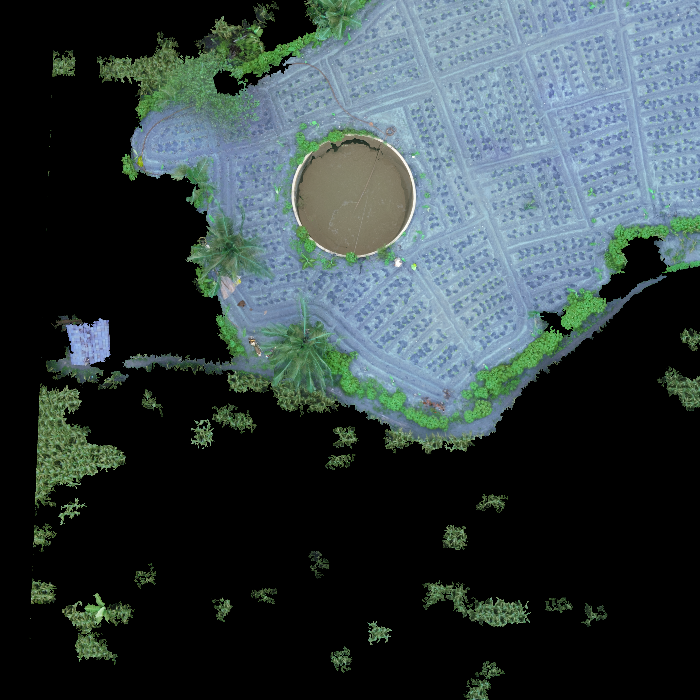

Cluster label:  1


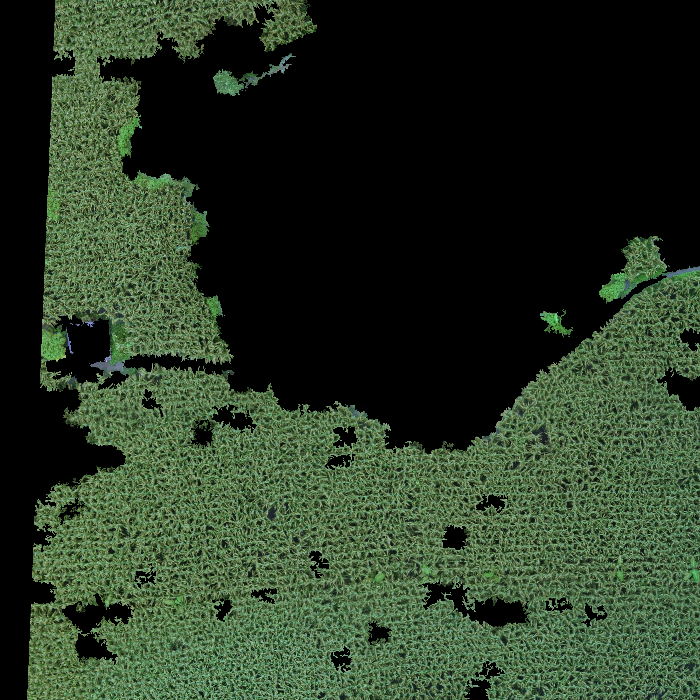

In [35]:
km = KMeans(n_clusters=2).fit(bovw_features)
print("================== Number of clusters = 2 ======================")
display_clusters(km.labels_,segments,image)

In [32]:
len(visual_words)

20

**Clustering the features after scaling**

================== Number of clusters = 2 ======================
Cluster label:  0


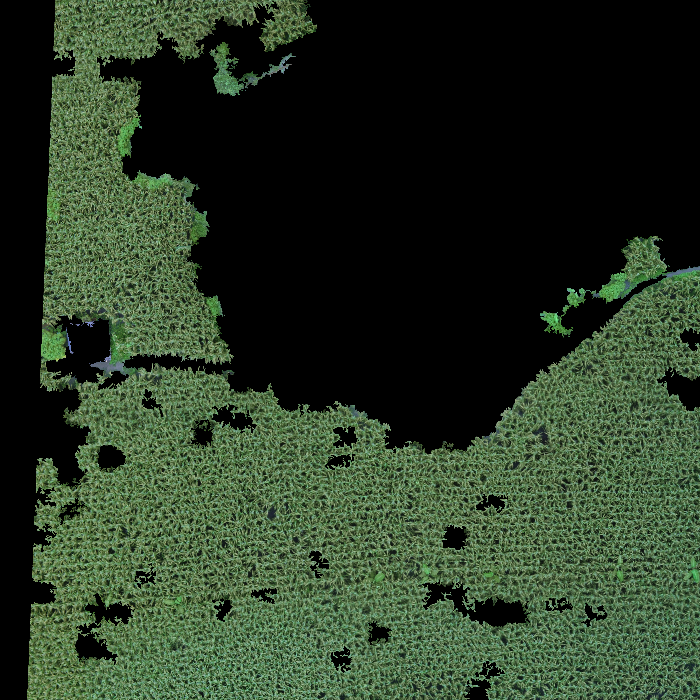

Cluster label:  1


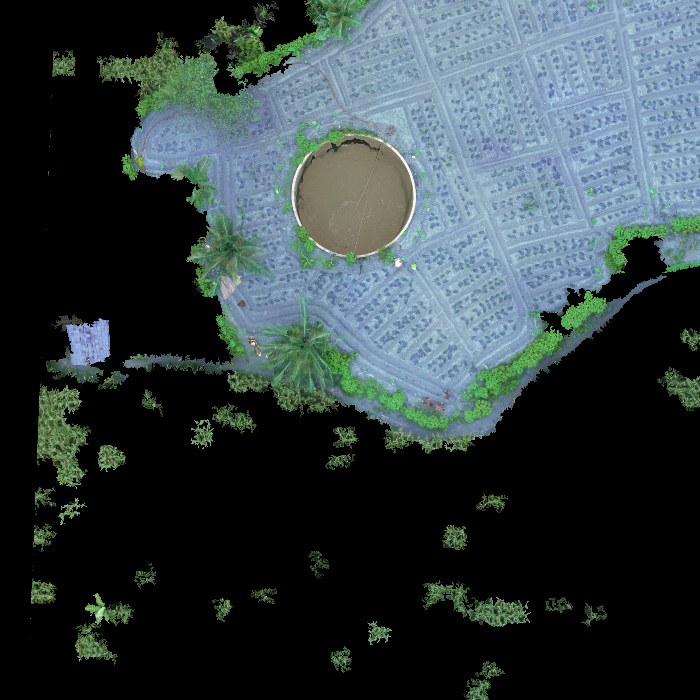

In [31]:
from sklearn.preprocessing import StandardScaler

bovw_features_normalized = StandardScaler().fit_transform(bovw_features)
km = KMeans(n_clusters=2).fit(bovw_features_normalized)
print("================== Number of clusters = 2 ======================")
display_clusters(km.labels_,segments,image)

**Clustering the features using DBSCAN algorithm**

In [22]:
dbscan = DBSCAN(eps=20).fit(bovw_features)

Cluster label:  -1


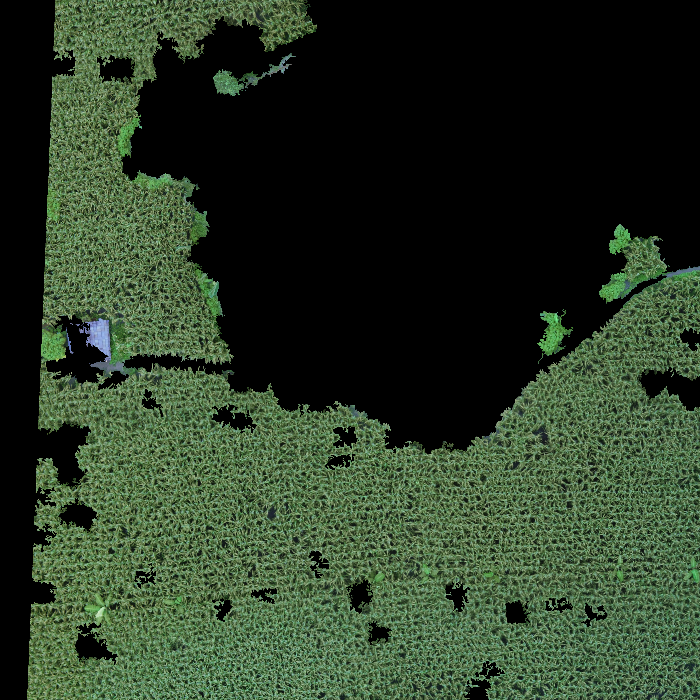

Cluster label:  0


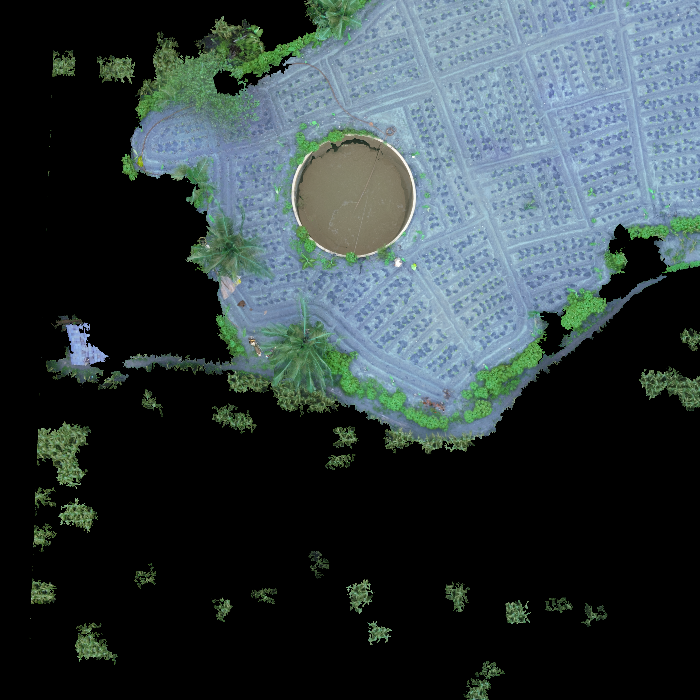

In [23]:
display_clusters(dbscan.labels_,segments,image)

**The Bag of Visual Words method is able to segment the corn field well. There are still some superpixels that get left out and a few others that get added in. The BoVW method provides the best results.**